I am not sure what these lines do, so I blocked them.  I don't think it's necessary if you're not using the practice files.

In [1]:
# %%bash
# # Preparation: make symbolic links for practice_train_10k.root and practice_test_10k.root
# PRACTICE_FILE_DIR=.
# ln -sf $PRACTICE_FILE_DIR/e_m_hadd.root ./train.root
# ln -sf $PRACTICE_FILE_DIR/e_m_hadd.root ./test.root

There is some sort of weird quirk happening.  The files I made don't have the whole-event information (neutrino type, etc) so this section of code will reprocess those files and add event information.

I am remaking the files already for other reasons, but this will be fixed soon with high stats files.

In [2]:
from larcv import larcv
from larcv.dataloader3 import larcv_threadio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys,time

# tensorflow/gpu start-up configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
#import tensorflow as tf

Welcome to JupyROOT 6.08/06
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
preprocess_cfg = '''
ProcessDriver: {
  Verbosity:       2
  EnableFilter:    false
  RandomAccess:    1
  RandomSeed:      0
  ProcessType:     ["EventPIDLabel"]
  ProcessName:     ["EventPIDLabel"]

  IOManager: {
    Verbosity:   2
    Name:        "IOManager"
    IOMode:      2
    OutFileName: "neutrino_images_with_labels.root"
    InputFiles:  ["/data/sbnd/sbnd_dl_samples/sbnd_dl_nueCC_larcv_dev.root","/data/sbnd/sbnd_dl_samples/sbnd_dl_numuCC_larcv_dev.root"]
    InputDirs:   []
    StoreOnlyType: ["image2d","particle"]
    StoreOnlyName: ["sbndwire","sbnd_eventlabel"]
  }

  ProcessList: {
    EventPIDLabel: {
      OutputProducer: "sbnd_eventlabel"
      ParticleProducer: "sbndseg"
    }
  }
}

'''

with open('preprocess.cfg', 'w') as _preprocess_cfg:
    _preprocess_cfg.write(preprocess_cfg)

Run that configuration file:

In [4]:
if False:
    proc = larcv.ProcessDriver('ProcessDriver')
    proc.configure('preprocess.cfg')

    proc.initialize()
    proc.batch_process()
    proc.finalize()

The following line will write out a config file to the current directory.  You don't have to do this, really, but I thought it would be useful to persist the config file.  You will need to change the input files, too.

In [5]:
config_file = '''
TrainIO: {
  Verbosity:       2
  EnableFilter:    false
  RandomAccess:    0
  RandomSeed:      0
  InputFiles:      ["neutrino_images_with_labels.root"]
  ProcessType:     ["BatchFillerImage2D","BatchFillerPIDLabel"]
  ProcessName:     ["main_data","main_label"]
  NumThreads:      1
  NumBatchStorage: 1

  ProcessList: {

    main_data: {
      Verbosity: 3
      ImageProducer: "sbndwire"
      Channels: [2]
    }
    main_label: {
      Verbosity: 3
      ParticleProducer: "sbnd_eventlabel"
      PdgClassList: [12, 14] #12 is nue, 14 is numu
    }
  }
}

'''

with open('config_train.cfg', 'w') as _train_cfg:
    _train_cfg.write(config_file)

In [6]:
DIR     = '.'
TRAIN_IO_CONFIG  = 'config_train.cfg'#os.path.join(DIR, 'config_train.cfg')
# TEST_IO_CONFIG   = 'config_test.cfg'#os.path.join(DIR, 'config_test.cfg' )
TRAIN_BATCH_SIZE = 5
# TEST_BATCH_SIZE  = 100
LOGDIR           = 'log'
ITERATIONS       = 5000
SAVE_SUMMARY     = 20
SAVE_WEIGHTS     = 100

# Check log directory is empty
train_logdir = os.path.join(LOGDIR,'train')
# test_logdir  = os.path.join(LOGDIR,'test')
if not os.path.isdir(train_logdir): os.makedirs(train_logdir)
# if not os.path.isdir(test_logdir):  os.makedirs(test_logdir)
if len(os.listdir(train_logdir)):
  sys.stderr.write('Error: train or test log dir not empty...\n')
  raise OSError

Above, I removed the test directory stuff.  I'm trying to simplify and get a working example with just training info.

In [7]:
#
# Step 0: IO
#
#for "train" data set
train_io = larcv_threadio()  # create io interface
print "Threaded IO Interface created."
train_io_cfg = {'filler_name' : 'TrainIO',
                'verbosity'   : 0,
                'filler_cfg'  : TRAIN_IO_CONFIG}
print type(train_io)
train_io.configure(train_io_cfg)   # configure
print "Train IO configured."
train_io.start_manager(TRAIN_BATCH_SIZE) # start read thread
print "Train IO manager started."
time.sleep(2)
train_io.next()
print "Train IO first batch read."

# # for "test" data set
# test_io = larcv_threadio()   # create io interface
# test_io_cfg = {'filler_name' : 'TestIO',
#                'verbosity'   : 0,
#                'filler_cfg'  : TEST_IO_CONFIG}
# test_io.configure(test_io_cfg)   # configure
# test_io.start_manager(TEST_BATCH_SIZE) # start read thread
# time.sleep(2)
# # test_io.next()

Threaded IO Interface created.
<class 'larcv.dataloader3.larcv_threadio'>
 setting verbosity 2
    [NORMAL]  <TrainIO0::configure> Instantiating Process ID=0 Type: BatchFillerImage2D w/ Name: main_data_t0
    [NORMAL]  <TrainIO0::configure> Instantiating Process ID=1 Type: BatchFillerPIDLabel w/ Name: main_label_t0
    [NORMAL]  <TrainIO::configure> Done configuration ...
    [NORMAL]  <TrainIO0IOManager::prepare_input> Opening a file in READ mode: neutrino_images_with_labels.root
    [NORMAL]  <TrainIO0IOManager::initialize> Prepared input with 606 entries...
Train IO configured.
Train IO manager started.
Train IO first batch read.


Warning in <TClass::TClass>: no dictionary for class thread is available


In [8]:
train_io.next()

In [9]:
images = train_io.fetch_data(key='main_data')
labels = train_io.fetch_data(key='main_label')

This is the training data, then.  You can build a network and train on it, and call train_io.next() to fetch the next batch.  I'll display the images so you can see them at least:

In [16]:
print labels.data()

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


Draw an image where the event is nue:

In [12]:
import numpy


In [22]:
nue_index = numpy.where(labels.data()[:,0] == 1)[0][0]
numu_index = numpy.where(labels.data()[:,1] == 1)[0][0]

In [23]:
print nue_index
print numu_index

0
2


In [39]:
shaped_images = numpy.reshape(images.data(), images.dim())
print shaped_images.shape
nue_image  = numpy.squeeze(shaped_images[nue_index])
numu_image = numpy.squeeze(shaped_images[numu_index])

(5, 1280, 1666, 1)


In [25]:
from matplotlib import pyplot as plt

(1280, 1666)


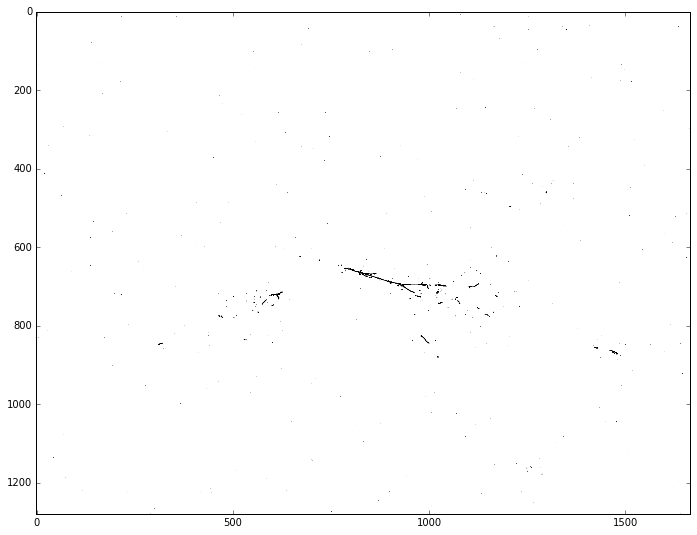

In [46]:
print nue_image.shape
fig = plt.figure(figsize=(16,9))
plt.imshow(nue_image,cmap='Greys',vmin=0, vmax=5)

(1280, 1666)


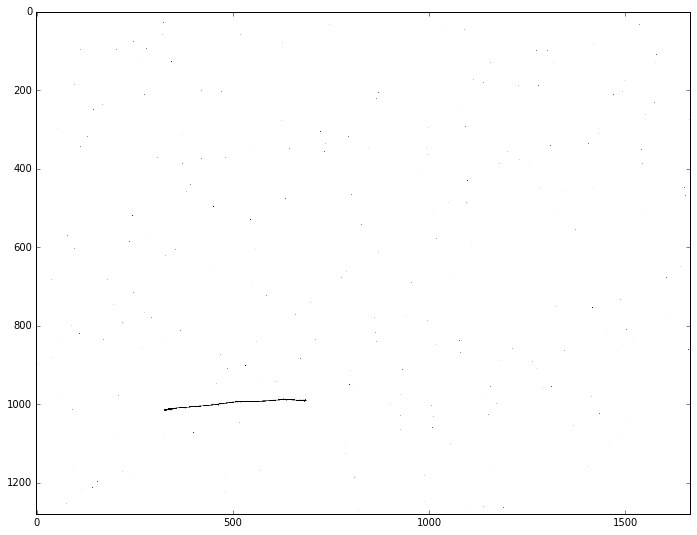

In [47]:
print numu_image.shape
fig = plt.figure(figsize=(16,9))
plt.imshow(numu_image,cmap='Greys',vmin=0, vmax=5)